<a href="https://colab.research.google.com/github/deqiangwang123/3253-Machine-Learning/blob/main/W4_Cluster_Assignment_Deqiang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#


## Get the data

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

### Import CSV into Google Colab.
If you do not remember how, you can refer to this document

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import fileinput

filePath = "/content/gdrive/MyDrive/Colab/data/LD2011_2014.txt"

In [3]:
import pandas as pd
data = pd.read_csv(filePath, sep=';', low_memory=False, index_col=0, decimal=',')

## Explore the data

In [4]:
data.shape

(140256, 370)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [6]:
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.629630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,119.212963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,127.314815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,122.685185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,29.833004,49.304994,55.109965,33.510085,15.163418,24.767073,36.914869,184.004498,6.187150,30.630277,121.762539,20.559679,7.376725,21.406990,163.373989,15.668009,14.982383,50.404422,58.850349,15.438616,67.355325,15.411176,24.848862,10.546950,87.882419,27.421373,83.373382,89.883837,13.055790,74.713009,...,221.827103,29.308875,63.745554,61.005710,54.978062,121.346269,31.362774,183.641656,2442.715562,100.342822,779.187866,204.096524,113.719204,130.361406,1565.976941,215.019347,1.844880,13.065485,144.052901,484.308083,1230.459794,77.096923,391.253968,90.126873,495.260113,82.164381,1408.881714,605.108383,81.531754,388.224080,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,20.347314,73.944242,48.044556,24.893022,23.555069,17.444889,24.282106,129.601771,4.200317,20.296580,82.811164,16.318638,5.507214,16.796146,114.749587,11.776842,11.001116,34.640532,43.366687,19.886410,45.064948,16.276663,21.896184,7.282169,58.235655,27.744751,57.795972,57.850121,21.827919,66.964774,...,80.838968,50.855355,46.935750,55.642929,53.671725,93.759147,61.485026,137.645418,2128.834941,93.301250,643.070730,182.112867,129.876419,128.555531,1175.512494,169.195334,4.086486,23.091625,134.333083,511.598370,1105.148746,95.232817,279.646061,99.558309,442.743660,108.329230,1243.202736,576.699851,85.363563,347.626599,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

### Plot 2 days of 2013 for 2 cliens

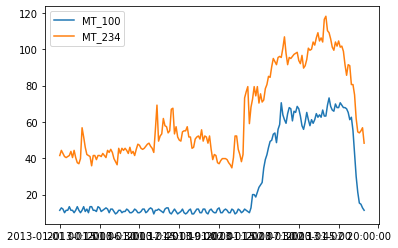

In [8]:
data_sample = data.loc['2013-01-01 00:15:00':'2013-01-03 00:00:00'][['MT_100','MT_234']]
data_sample.plot()
plt.show()

### Plot the 2 days of 2012 for the first 2 clients

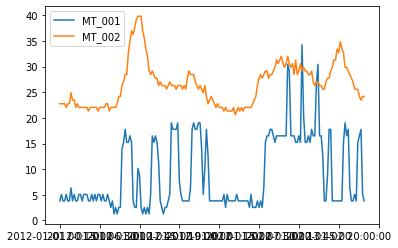

In [9]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### Very Important Note: 
We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

## Data for analysis

In [10]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [11]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [12]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [13]:
clients = data2013.columns

In [14]:
clients

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=370)

In [15]:
clients_no_demand13 = clients[data2013.mean()==0]
clients_no_demand_13_14 = clients_no_demand13.append(clients[data2014.mean()==0])

In [16]:
clients_no_demand_13_14.array

<PandasArray>
['MT_106', 'MT_107', 'MT_108', 'MT_109', 'MT_110', 'MT_111', 'MT_112',
 'MT_113', 'MT_115', 'MT_116', 'MT_117', 'MT_120', 'MT_121', 'MT_122',
 'MT_133', 'MT_160', 'MT_178', 'MT_181', 'MT_223', 'MT_337', 'MT_347',
 'MT_223']
Length: 22, dtype: object

In [17]:
type(clients_no_demand_13_14)

pandas.core.indexes.base.Index

In [18]:
data_13_14 = data2013.append(data2014) # appending 2013 and 2014

# drop clients with 0 demand
data_13_14 = data_13_14.drop(clients_no_demand_13_14, axis=1) 
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


### Getting average curves per client

#### Add "hour" column from index

In [19]:
data = data_13_14.copy()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70080 entries, 2013-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 349 entries, MT_001 to MT_370
dtypes: float64(349)
memory usage: 187.1+ MB


In [21]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.0,38.142620,33.822591,0.0,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.133250,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.0,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.0,175.824176,...,136.985294,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.040080,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.0,43.946932,35.737077,0.0,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.642590,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.0,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.0,173.076923,...,131.102941,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.040080,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,62.593145,0.0,39.800995,33.822591,0.0,41.002278,69.182390,380.191693,11.557789,50.220264,151.832461,27.397260,12.532982,32.921811,299.065421,26.271186,26.187576,95.283927,62.617408,0.0,111.842105,44.381492,52.587646,27.234637,130.801688,13.769363,125.725338,104.712042,0.0,175.824176,...,134.044118,55.09375,146.990741,2.910361,43.298969,17.498713,29.245767,92.519685,90.909091,1551.219512,32.967033,328.715365,74.260995,30.674847,63.731170,903.381643,119.675456,0.00000,64.386318,174.129353,648.888889,39.009752,184.733804,19.038076,284.627093,21.317829,719.696970,334.928230,35.612536,163.377193,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,59.612519,0.0,37.313433,34.460753,0.0,41.571754,63.791554,351.437700,11.055276,58.149780,167.539267,24.906600,11.873351,32.921811,289.719626,24.576271,27.405603,88.546679,61.991234,0.0,103.618421,44.381492,53.422371,25.139665,119.549930,15.490534,119.922631,107.329843,0.0,170.329670,...,125.205882,46.33125,179.398148,2.910361,42.783505,17.498713,29.245767,91.535433,90.909091,1156.097561,32.967033,332.493703,72.819034,30.674847,61.993048,884.057971,120.689655,40.69176,63.883300,174.129353,635.555556,39.009752,187.940988,19.038076,252.663623,30.038760,712.121212,334.928230,35.612536,162.280702,44.254104,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,229.166667,6.783493,239.057239,57.692308,74.193548,64.828614,0.0,44.776119,35.737

In [22]:
# add column of hour
data['hour'] = data.index.map(lambda x: x[11:])

In [23]:
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.0,38.142620,33.822591,0.0,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.133250,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.0,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.0,175.824176,...,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.040080,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.0,43.946932,35.737077,0.0,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.642590,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.0,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.0,173.076923,...,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.040080,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,62.593145,0.0,39.800995,33.822591,0.0,41.002278,69.182390,380.191693,11.557789,50.220264,151.832461,27.397260,12.532982,32.921811,299.065421,26.271186,26.187576,95.283927,62.617408,0.0,111.842105,44.381492,52.587646,27.234637,130.801688,13.769363,125.725338,104.712042,0.0,175.824176,...,55.09375,146.990741,2.910361,43.298969,17.498713,29.245767,92.519685,90.909091,1551.219512,32.967033,328.715365,74.260995,30.674847,63.731170,903.381643,119.675456,0.00000,64.386318,174.129353,648.888889,39.009752,184.733804,19.038076,284.627093,21.317829,719.696970,334.928230,35.612536,163.377193,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,59.612519,0.0,37.313433,34.460753,0.0,41.571754,63.791554,351.437700,11.055276,58.149780,167.539267,24.906600,11.873351,32.921811,289.719626,24.576271,27.405603,88.546679,61.991234,0.0,103.618421,44.381492,53.422371,25.139665,119.549930,15.490534,119.922631,107.329843,0.0,170.329670,...,46.33125,179.398148,2.910361,42.783505,17.498713,29.245767,91.535433,90.909091,1156.097561,32.967033,332.493703,72.819034,30.674847,61.993048,884.057971,120.689655,40.69176,63.883300,174.129353,635.555556,39.009752,187.940988,19.038076,252.663623,30.038760,712.121212,334.928230,35.612536,162.280702,44.254104,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649,01:00:00
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,229.166667,6.783493,239.057239,57.692308,74.193548,64.828614,0.0,44.776119,35.737077,0.0,41

#### Getting average per client

In [24]:
# group the data by the hour column, find the 
# create a new colomn, use groupby to agg the attribute as mean 
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

In [25]:
type(average_curves)

pandas.core.frame.DataFrame

In [26]:
average_curves.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00:00:00,5.008344,26.045909,1.938755,130.551843,60.374206,191.136660,7.772366,242.027582,51.585401,54.837237,42.262622,88.726319,46.342488,36.804469,27.339947,37.757044,46.259031,233.244343,8.727886,47.221049,157.293983,23.349085,10.342646,30.964729,205.274613,24.901323,25.411710,77.238388,73.936576,36.661198,84.744503,28.798168,39.307522,18.857618,121.582567,21.189258,122.389444,104.733558,28.613475,79.643986,...,144.845266,53.765788,109.711124,25.563334,89.332721,49.267127,35.202457,85.837558,147.067544,2999.331774,80.969442,772.007522,178.349843,39.246996,88.554580,2009.403746,307.028536,25.529899,137.375624,194.745451,769.826484,100.636118,421.909021,54.916683,552.467630,36.967718,1115.390203,786.599594,49.238965,342.114275,119.625903,36306.438356,1333.223513,1652.677460,37.831080,16.499275,676.790504,148.683880,799.235729,17333.891151
00:15:00,4.917947,25.833512,1.911381,125.863125,57.586034,179.297130,7.426996,232.516950,50.016764,53.424658,40.008779,84.153308,48.014494,36.523852,26.080465,35.927700,44.359931,218.862970,8.254285,45.631525,147.357097,23.063341,9.710124,29.100663,193.906030,23.796146,24.031001,74.074123,72.246764,34.882691,80.008562,28.173387,37.487136,18.251129,116.162842,20.899253,115.693808,99.677257,26.637999,75.974710,...,135.636281,52.267671,112.044964,24.030013,65.792967,34.538456,32.738250,80.271815,142.323430,2666.673349,76.118220,620.409924,151.621219,37.688041,75.400403,1919.647939,286.154103,43.478867,127.241531,181.557964,730.124810,95.728042,420.353757,52.186565,492.702404,35.421313,1005.738896,577.003998,51.676228,291.687695,119.540837,32137.534247,979.064794,1443.711083,33.942955,16.580232,659.875882,155.464587,795.100028,17466.227323
00:30:00,4.984007,24.754964,1.909001,121.566990,55.476111,171.554958,7.179972,225.317098,48.843280,52.514361,38.368414,82.745555,49.468411,36.522104,25.151421,34.440041,42.625755,210.184253,7.923866,44.923058,141.285950,22.361350,9.210431,28.069978,185.174754,22.319480,22.787112,72.068770,70.764533,33.656759,76.613194,27.670198,36.427150,17.709689,111.388552,20.477212,110.193159,95.469053,25.415798,72.790908,...,132.261765,52.212466,104.945142,22.680881,64.622228,29.199303,32.277880,79.856542,136.968511,2321.122619,70.681921,599.389255,134.323612,36.445920,72.010667,1780.821918,258.416461,34.114188,106.183677,175.560553,705.071537,94.535963,490.040156,51.317704,432.933008,34.154986,790.421337,446.283673,78.827616,262.020848,111.557303,27249.178082,938.598925,1324.501868,31.044275,15.940589,655.911819,153.879754,777.630258,17605.301740


In [27]:
average_curves.mean()

MT_001        5.191112
MT_002       28.106884
MT_003        1.954785
MT_004      114.508535
MT_005       50.884390
              ...     
MT_366       12.144033
MT_367      556.904701
MT_368      127.032402
MT_369      820.311872
MT_370    17456.658722
Length: 349, dtype: float64

In [28]:
average_curves_norm = average_curves/(average_curves.mean())

In [29]:
average_curves_norm

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,1.067727,0.899154,0.594005,0.812633,0.900893,1.139499,0.942227,0.943290,1.071027,1.112666,0.976258,0.826026,1.041795,0.979740,0.950892,1.198976,1.223172,1.135498,0.922252,1.186509,0.956077,1.025583,0.969207,1.309342,1.023562,0.567422,1.092313,0.874111,1.095065,0.945736,...,0.710134,0.567060,0.555638,0.447612,1.029641,0.593204,0.476664,0.540194,0.603108,0.923516,0.603549,0.753769,0.710593,0.261940,0.513765,0.985052,1.080529,1.775050,0.713224,0.319943,0.486279,1.072717,0.826119,0.439183,0.845824,0.372696,0.609931,1.022005,0.602145,0.678209,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,1.010786,0.852811,0.615436,0.806437,0.859391,1.084290,0.903545,0.885129,1.012910,1.075212,0.914584,0.815918,0.978083,0.920760,0.898229,1.145762,1.156713,1.088980,0.901174,1.128949,0.902647,1.003333,0.924322,1.267231,0.977935,0.559656,1.032555,0.831911,1.019462,0.902165,...,0.664985,0.551260,0.567458,0.420764,0.758324,0.415863,0.443297,0.505168,0.583653,0.821088,0.567388,0.605753,0.604099,0.251535,0.437449,0.941051,1.007065,3.023012,0.660610,0.298278,0.461200,1.020400,0.823074,0.417349,0.754324,0.357106,0.549971,0.749683,0.631951,0.578244,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,0.969343,0.838545,0.634072,0.806398,0.828778,1.039392,0.868223,0.850030,0.972363,1.058519,0.876902,0.791083,0.927749,0.888148,0.857783,1.074662,1.096839,1.059499,0.882685,1.089273,0.864340,0.985413,0.898186,1.229638,0.937742,0.548354,0.983462,0.796789,0.972687,0.864359,...,0.648441,0.550678,0.531500,0.397140,0.744830,0.351576,0.437064,0.502555,0.561693,0.714690,0.526866,0.585229,0.535181,0.243245,0.417783,0.872996,0.909448,2.371901,0.551282,0.288425,0.445375,1.007694,0.959523,0.410401,0.662818,0.344339,0.432228,0.579843,0.963986,0.519432,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,0.931357,0.818549,0.604342,0.789818,0.795739,0.993977,0.831421,0.811675,0.933928,1.031928,0.849460,0.722766,0.880511,0.854794,0.831037,1.011779,1.050137,1.033041,0.871205,1.029465,0.831398,0.977535,0.860856,1.205926,0.902852,0.548796,0.956102,0.766022,0.929884,0.842819,...,0.642507,0.548868,0.540927,0.378948,0.726510,0.340744,0.428850,0.499194,0.491703,0.547632,0.380067,0.479870,0.432177,0.236733,0.371677,0.677297,0.639679,2.038595,0.470241,0.281819,0.413709,0.925264,0.996405,0.410675,0.505291,0.317293,0.406430,0.407983,0.835887,0.439098,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,0.898064,0.802658,0.574845,0.763413,0.770768,0.965608,0.800586,0.772275,0.907320,0.992228,0.821972,0.704117,0.838825,0.826522,0.811437,0.960131,0.995524,0.993714,0.853037,1.001223,0.803945,0.997068,0.828038,1.181616,0.866682,0.543934,0.929947,0.751431,0.882536,0.821145,...,0.636550,0.530001,0.551880,0.373950,0.699937

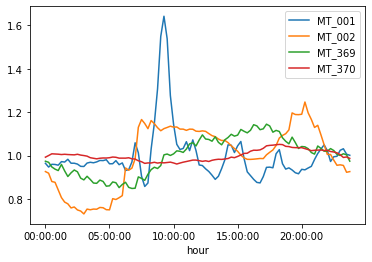

In [30]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

In [31]:
ind = np.array(average_curves_norm.index)

In [32]:
type(ind)

numpy.ndarray

In [33]:
ind.shape


(96,)

## Exercise 1:

a. Using the functions described in Module 3, determine what is the optimal number of clusters based on _intertia_ and based on _silhouette_. Justify your choice


### Optimal K

In [34]:
#function for calculating inertia
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [35]:
X = average_curves_norm.copy()
X.shape

(96, 349)

In [36]:
X = np.array(X.T) # put it on the right format
X.shape

(349, 96)

In [37]:
#try different K values for clustering and find the optimal K
inertias_1 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

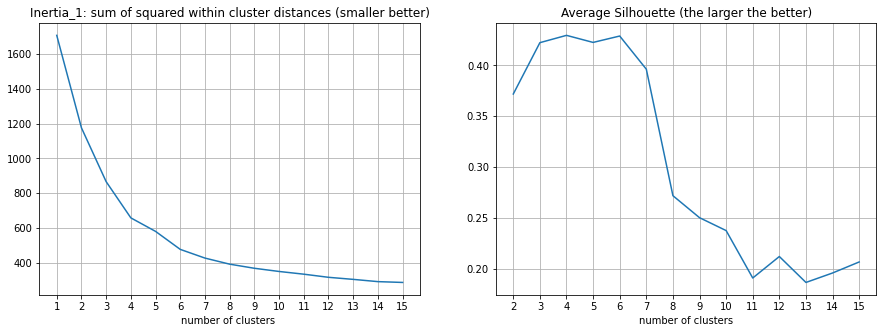

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Inertia_1: sum of squared within cluster distances (smaller better)")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters ')
plt.grid()
    
plt.subplot(1,2,2)  
plt.title("Average Silhouette (the larger the better)")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

In [39]:
print(f"Optimal cluster number: {np.argmax(silhouette_avgs) + 2} \nWith silhouette score: {np.max(silhouette_avgs)}")

Optimal cluster number: 4 
With silhouette score: 0.4296355372224769


b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [40]:
# Clustering with optimal k
optimalK = 4
kmeans = KMeans(optimalK, random_state=0).fit(X)  

In [41]:
colors = 'bgry'
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 3, 2, 0, 0, 0, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0, 2, 0, 2,
       3, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
kmeans.labels_.shape

(349,)

In [43]:
X.shape

(349, 96)

### Plot clusters

TypeError: ignored

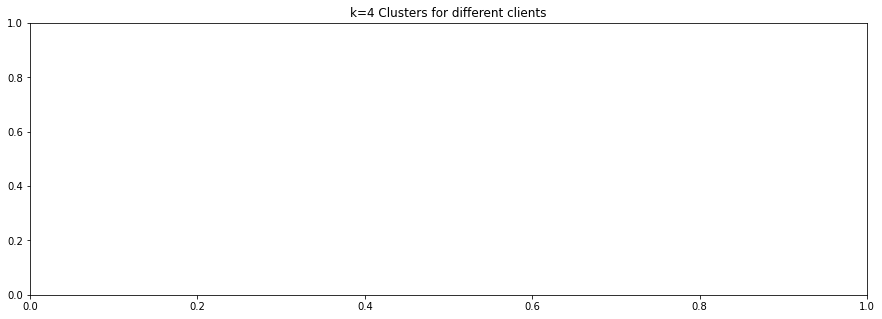

In [78]:
# Plot curves with clusters
plt.figure(figsize=(15,5))
plt.title("k=4 Clusters for different clients", fontsize=12)
for J in range(optimalK):
  X_J = X[kmeans.labels_==J]
  # print(X_J.shape)
  plt.ylabel("usage_average_norm", fontsize=12)
  plt.xlabel("hour", fontsize=12)
  plt.xticks(list(range(0,96+1,4)))
  print(f"Cluster {J} size: {len(X_J[:,1])} with color {colors[J]}")
  for z in range(len(X_J[:,1])):
    plt.plot(np.arange(0,24, 0.25), X_J[z,:] , c=colors[J])

Cluster 0 size: 35 with color b
Cluster 1 size: 35 with color g
Cluster 2 size: 35 with color r
Cluster 3 size: 35 with color y


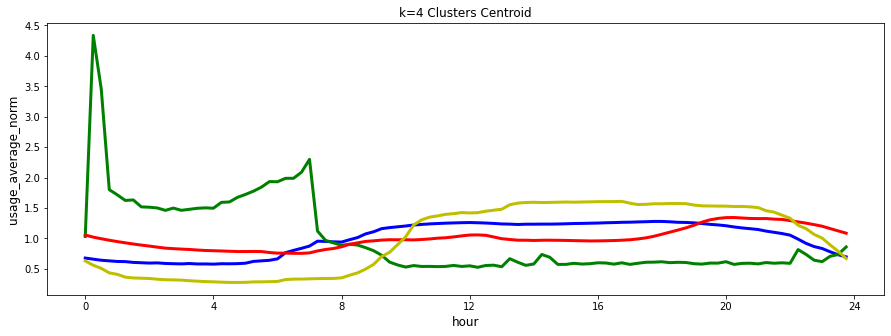

In [45]:
# Plot centroild
# Plot curves with clusters
plt.figure(figsize=(15,5))
plt.title("k=4 Clusters Centroid for different clients", fontsize=12)
for J in range(optimalK):
  plt.ylabel("usage_average_norm", fontsize=12)
  plt.xlabel("hour", fontsize=12)
  plt.xticks(list(range(0,96+1,4)))
  print(f"Cluster {J} size: {len(X_J[:,1])} with color {colors[J]}")
  plt.plot(np.arange(0,24, 0.25), kmeans.cluster_centers_[J,:] , c=colors[J],linewidth=3)


## Exercise 2:

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [46]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

In [52]:
oneClient.shape

(70080,)

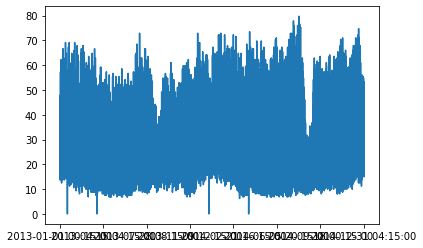

In [55]:
type(oneClient)
oneClient.plot()

In [51]:
len(X)

730

In [62]:
X[1].shape

(96,)

The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [64]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

In [65]:
len(daysyear)

730

In [67]:
daysyear[0]

'tue-2013-01-01'

The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [68]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

### Kmeans training

In [69]:
#try different K values for clustering and find the optimal K
inertias_1 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

### Optimal K

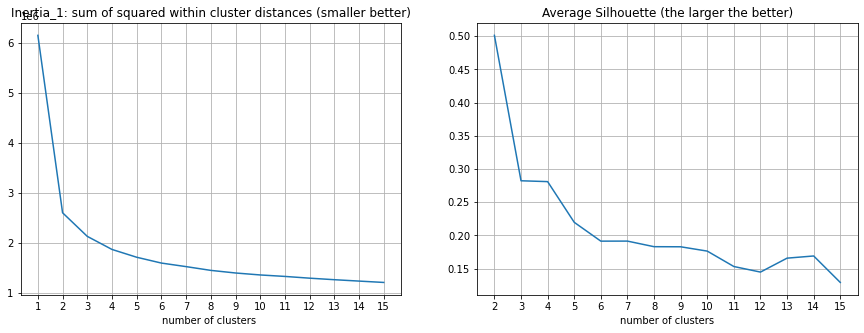

In [70]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Inertia_1: sum of squared within cluster distances (smaller better)")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters ')
plt.grid()
    
plt.subplot(1,2,2)  
plt.title("Average Silhouette (the larger the better)")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

In [71]:
# Clustering with optimal k
optimalK = 2
kmeans = KMeans(optimalK, random_state=0).fit(X)  

In [72]:
kmeans.labels_

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,

In [ ]:
len(X)

730

In [ ]:
colors = 'bg'
kmeans.labels_.shape

(730,)

In [ ]:
type(kmeans.labels_)

numpy.ndarray

### Plot clusters

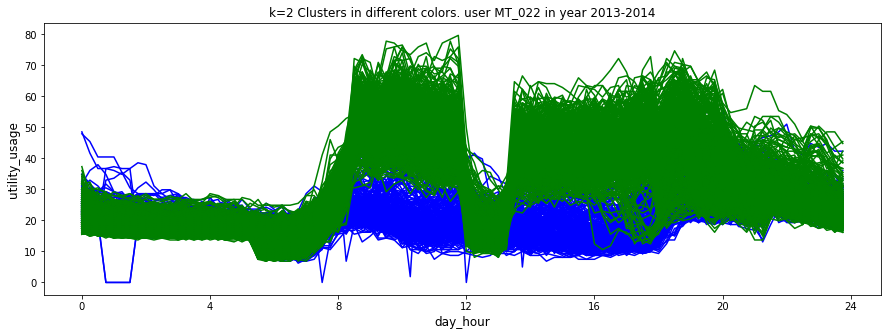

In [77]:
# Plot curves with clusters
plt.figure(figsize=(15,5))
plt.title("k=2 Clusters in different colors. user MT_022 in year 2013-2014", fontsize=12)
plt.ylabel("utility_usage", fontsize=12)
plt.xlabel("day_hour", fontsize=12)
plt.xticks(list(range(0,96+1,4)))
for J in range(optimalK):
  for i in range(len(X)):
    if kmeans.labels_[i] == J:
      plt.plot(np.arange(0,24, 0.25),X[i], c=colors[J])


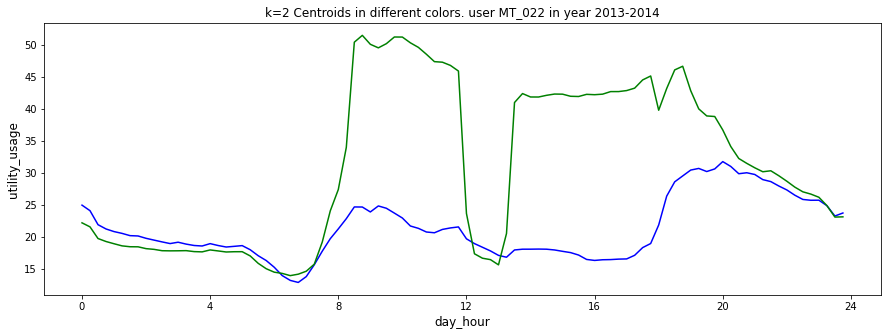

In [80]:
# Plot centroids
plt.figure(figsize=(15,5))
plt.title("k=2 Centroids in different colors. user MT_022 in year 2013-2014", fontsize=12)
plt.ylabel("utility_usage", fontsize=12)
plt.xlabel("day_hour", fontsize=12)
plt.xticks(list(range(0,96+1,4)))
plt.plot(np.arange(0,24, 0.25),kmeans.cluster_centers_[0,:], c=colors[0])
plt.plot(np.arange(0,24, 0.25),kmeans.cluster_centers_[1,:], c=colors[1])

### Interpret the two clusters

In [81]:
daysyear[0]

'tue-2013-01-01'

In [95]:
weekendcheck = [x.startswith('s') for x in daysyear]
# [x[0:3] in ('sat', 'sun') for x in daysyear]

In [96]:
labelmatch = list(compress(kmeans.labels_, weekendcheck))

In [104]:
var, count = np.unique(labelmatch, return_counts=True)
print(f"{count[0]} instants in weekend are clustered into cluster {var[0]}")
print(f"{count[1]} instants in weekend are clustered into cluster {var[1]}")

162 instants in weekend are clustered into cluster 0
46 instants in weekend are clustered into cluster 1


In [105]:
var_w, count_w = np.unique(weekendcheck, return_counts=True)
print(var_w, count_w)
var_l, count_l = np.unique(kmeans.labels_, return_counts=True)
print(var_l, count_l)

[False  True] [522 208]
[0 1] [219 511]


In [108]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Clusters","Weekdays", "Weekend"]
table.add_row(["1", count_l[1]-count[1],count[1]])
table.add_row(["0", count_l[0]-count[0],count[0]])
print(table)

+----------+----------+---------+
| Clusters | Weekdays | Weekend |
+----------+----------+---------+
|    1     |   465    |    46   |
|    0     |    57    |   162   |
+----------+----------+---------+


### Conclusion:

As shown above, 91% of the instance in Cluster 1 are from weekdays and 74% of the instances in Cluster 0 are from weekends. It is fair to see the K=2 Clustering seperate the daily electricity usage by MT-022 by weekdays and weekend. Further more, Cluster 0 as the usage from weekends has lower level than Cluster 1.